<a href="https://colab.research.google.com/github/tylee33/DLforFinance/blob/master/Pairs_Trading(LSTM).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import keras.callbacks
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dense, Dropout
from keras.layers.recurrent import LSTM
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy.random as random

In [0]:
LOOKBACK_WINDOW = 15
PREDICT_WINDOW = 1
BATCH_SIZE = 1     #e.g if 3, then trains with 3 samples/lookback windows, each with 15 timesteps and 2 features at once before updating gradients.
HIDDEN = 32
DROPOUT = 0.3
OPTIMIZER = 'adam'
EPOCHS = 3

BATCH_SIZE - 그라디언트 업데이트 당 샘플 수입니다. 가중치를 업데이트하기 전에 LSTM 네트워크를 학습하는 데 사용되는 N 개의 샘플 집합입니다. 일괄 처리로 인해 모델이 한 번 업데이트됩니다. 따라서 배치 크기가 작을수록 학습 과정이 빨라집니다. 

batch_input_shape - 형상을 3D 배열로 전달하는 경우 : (batch_size, timesteps, input_dim); feature를 2 차원 배열로 전달하는 경우 : (batch_size, output_dim). batch_input_shape는 신경망의 순차 분류가 정의 된 배치 크기의 입력 데이터를 받아 들일 수 있으며, 가변 길이 벡터의 생성을 제한합니다. 

EPOCH - 일반적으로 "전체 데이터 세트에 대해 하나의 통과"로 정의되는 임의 컷오프는 교육을 별도의 단계로 분리하는 데 사용되며 로깅 및 정기 평가에 유용합니다. 

HIDDEN - 숨겨진 레이어의 수입니다.

LOOKBACK_WINDOW - 일괄 처리의 타임 스텝 수입니다. 

DROPOUT - 네트워크를 학습하는 동안 셀 상태에 대한 입력 및 순환 연결이 활성화 및 가중치 업데이트에서 확률 적으로 제외되는 정규화 방법입니다. 이렇게하면 모델 성능을 향상시키기 위해 지나친 조정이 줄어 듭니다.

In [0]:
def coint_path(N,delta,sigma,PO):
   X = [PO]
   Y = [PO]
   for i in range(N):
      dX = random.randn()+delta*(Y[-1] - X[-1])
      X.append(X[-1]+dX)
      dY = random.randn()+sigma*(X[-1] - Y[-1])
      Y.append(Y[-1]+dY)
 
   return X,Y
 
#create artificial cointegrated series
X,Y = coint_path(60,0.9,0.1,0)

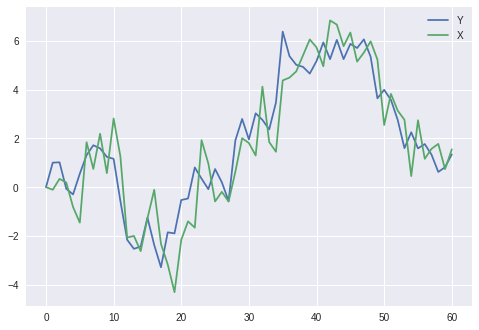

In [103]:
plt.plot(np.array(Y),label='Y')
plt.plot(np.array(X),label='X')
plt.legend()
plt.show();

우리는 두 개의 시리즈를 함께 다차원 배열로 '쌓아야'합니다. 그런 다음 sklearn의 MinMaxScaler 함수를 사용하여 새로 생성 된 다차원 배열을 정규화합니다. 이 값은 -1과 1 사이의 값으로 변환됩니다.

In [0]:
def prep_feature_data(X,Y):
    data = np.column_stack([X,Y])
    scaler = MinMaxScaler(feature_range=(-1,1)) #다차원 배열 정규화
    data = scaler.fit_transform(data)
    return data
 
#format features for the model into a multidimensional array
data = prep_feature_data(X,Y)

이것은 다차원 배열과 같이 이제 형상 데이터가 어떻게 생겼는지를 나타냅니다.

In [105]:
print(data[0:3])
print(data.shape)

[[-0.22701844 -0.32011537]
 [-0.24623211 -0.11204855]
 [-0.16604053 -0.10926056]]
(61, 2)


이제 우리는 nb_samples에 대해이 정수 값을 계산합니다. nb_samples는 전환 확인 기간을 설정할 다음 단계의 정수입니다. 얼마나 많은 총 샘플 / 관측치보다 예측 및 전환 확인 기간이 적어 지므로 이러한 창 생성을 중단해야하는지 알 수 있습니다.

In [0]:
def window_stop(data,LOOKBACK_WINDOW,PREDICT_WINDOW):
    examples = LOOKBACK_WINDOW
    y_examples = PREDICT_WINDOW
    nb_samples = len(data) - examples - y_examples #makes sure it can be split into lookback windows properly
    return nb_samples
 
#ensure it can be divided into the lookback window/batch size
nb_samples = window_stop(data,LOOKBACK_WINDOW,PREDICT_WINDOW)

In [73]:
print(nb_samples)

45


이제는 더 많은 형식 지정이 기능 데이터에 필요합니다. 여기서는 LSTM에 반영 할 전환 확인 기간을 만듭니다.

np.expand_dims는 확장 배열 모양의 축 위치에 나타날 새 축을 삽입하여 배열의 모양을 확장합니다. 각 데이터 전환 확인 기간의 이전 모양은 (관측 개수, 기능 개수) 즉, 20 개의 전환 확인 기간이 있고 2 개의 기능이있는 경우 이전 모양은 (20,2)이고 새 모양은 (1, 20, 2)입니다.

이렇게하면 모양이 (800,2)가 아닌 (40,2,2) 별도의 전환 확인 기간이 모두 연결되면됩니다. 즉 2 개의 기능이있는 20 개의 룩백 샘플로 구성된 40 개의 룩백 (lookback) 윈도우가 있습니다.

In [0]:
def input_features(nb_samples,LOOKBACK_WINDOW):
    input_list = [np.expand_dims(data[i:LOOKBACK_WINDOW+i,:], axis=0) for i in range(nb_samples)] #here nb_samples comes in handy
    input_mat = np.concatenate(input_list, axis=0)
    return input_mat
 
#format the features into the batch size
input_mat = input_features(nb_samples,LOOKBACK_WINDOW)

이것은 새로운 입력 행렬의 모양을 미리 보여줍니다. 전환 확인 기간은 항상 한 번에 한 단계 앞으로 이동하는 방법에 유의하십시오. 데이터를 20 개의 샘플 그룹으로 단순히 나누는 것과 같지 않습니다.

In [108]:
print(input_mat[0:2]) #the second sample of features will become the first sample in the next window
print(input_mat.shape)

[[[-0.22701844 -0.32011537]
  [-0.24623211 -0.11204855]
  [-0.16604053 -0.10926056]
  [-0.19285018 -0.33406838]
  [-0.3727985  -0.38184457]
  [-0.48811632 -0.20575102]
  [ 0.10386427 -0.0486566 ]
  [-0.09296896  0.0356976 ]
  [ 0.16624383  0.0088588 ]
  [-0.12385044 -0.06313628]
  [ 0.27848516 -0.07963483]
  [-0.00122742 -0.43767753]
  [-0.59782819 -0.76652298]
  [-0.58583586 -0.84362597]
  [-0.69777841 -0.82392044]]

 [[-0.24623211 -0.11204855]
  [-0.16604053 -0.10926056]
  [-0.19285018 -0.33406838]
  [-0.3727985  -0.38184457]
  [-0.48811632 -0.20575102]
  [ 0.10386427 -0.0486566 ]
  [-0.09296896  0.0356976 ]
  [ 0.16624383  0.0088588 ]
  [-0.12385044 -0.06313628]
  [ 0.27848516 -0.07963483]
  [-0.00122742 -0.43767753]
  [-0.59782819 -0.76652298]
  [-0.58583586 -0.84362597]
  [-0.69777841 -0.82392044]
  [-0.45662849 -0.57832139]]]
(45, 15, 2)


마지막으로 우리의 Feature Data Set가 준비되었습니다!

이제 목표 값을 만듭니다. 이 예에서 우리는 LSTM 모델을 훈련하여 두 피쳐 간의 기울기 (베타)를 기반으로 선형 회귀선의 절편을 예측하려고합니다.

In [0]:
def target_values(input_mat):
    targets = []
    for i in range(len(input_mat)):
        X1 = input_mat[i].T[0]
        X2 = input_mat[i].T[1]
        beta = np.polyfit(X1,X2,1)[0] #the slope is calculated from each lookback window 
        #targets.append(X1[-1] - beta*X2[-1])
        #targets = np.array(X1[-1] - beta*X2[-1]) 
        targets = np.append(targets, X1[-1]-beta*X2[-1])
        targets = np.array(targets)
  
    return targets

In [0]:
#format the targets into the batch size
targets = target_values(input_mat)

In [111]:
print(targets)
print(targets.shape)

[-0.02538364  0.02415468  0.43438918  0.26149216 -0.20152613 -0.46927685
 -0.29747156 -0.18410668 -0.43013045  0.25496894  0.11556141 -0.25550088
 -0.11287485 -0.10629178 -0.15871493 -0.04512547  0.03619763 -0.24549307
  0.34055387 -0.0075504  -0.23907352 -0.36737035 -0.19625962 -0.17308257
  0.00883774  0.27432831  0.12731167 -0.14250111  0.46878125  0.33475358
  0.30177112  0.37631112  0.17771629  0.23805338  0.57681483  0.72649717
  0.04582921  0.24343401  0.16745949  0.25907657 -0.25920669  0.25757496
 -0.05678766  0.09562598  0.27573018]
(45,)


In [0]:
class LossHistory(keras.callbacks.Callback):
  def on_train_begin(self, logs={}):
    self.losses = [] 
    
  def on_batch_end(self, batch, logs={}):
    self.losses.append(logs.get('loss'))

In [0]:
def basic_LSTM_model(BATCH_SIZE,HIDDEN,LOOKBACK_WINDOW,DROPOUT,OPTIMIZER,EPOCHS,input_mat,targets):
    num_features = input_mat.shape[2] #this is the same as input dimension, used in describing batch_input_shape
    model = Sequential()
    
    model.add(LSTM(HIDDEN,batch_input_shape=(BATCH_SIZE,LOOKBACK_WINDOW,num_features)))
    model.add(Dropout(DROPOUT))
    model.add(Dense(1)) #the output is one dimensional
    
    model.compile(loss='mse',optimizer=OPTIMIZER)
    history = LossHistory()
    predictions,actuals,scores = [],[],[]
    
    assert(len(input_mat)==len(targets)) #checks each sample has a corresponding target value 
    
    for i in range(1,len(input_mat)):
        trainX = input_mat[0:i]
        trainY = targets[0:i]
        testX = input_mat[i].reshape(1,input_mat[0].shape[0],input_mat[0].shape[1]) #convert the input into 3 dimensional array
        testY = np.array([targets[i]]).reshape(1,1) #convert the target value into a 2 dimensional array
  
 #walk forward training, to predict the next timestep 
 #you can adjust the verbose parameter to 1 or 2 to watch the LSTM's progress 
    model.fit(trainX,trainY,nb_epoch=EPOCHS,batch_size=BATCH_SIZE,callbacks=[history],verbose=0)
    prediction = model.predict(testX,batch_size=BATCH_SIZE) 
    score = model.evaluate(testX,testY,batch_size=BATCH_SIZE,verbose=0)
    
    predictions.append(prediction[0][0])
    actuals.append(targets[i])
    scores.append(score)
    
    return model,history,predictions,actuals,scores

In [0]:
def evaluate_walk_forward_LSTM(model,history,predictions,actuals,scores):
   print(np.mean(scores[int(len(scores)*0.75):])) #since the latter predictions have been trained on more data, we take the average of the testing loss scores for the last quarter of predictions
  
   plt.figure(1)
   plt.plot(history.losses)
   plt.title('Loss History')
   plt.figure(2)
   plt.plot(scores)
   plt.title('Testing Loss')
   plt.figure(3)
   plt.plot(actuals,'b-',label='actual')
   plt.plot(predictions,'g-',label='prediction')
   plt.title('Basic LSTM')
   plt.legend()
   plt.grid('on')
   plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


0.04802286624908447


/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


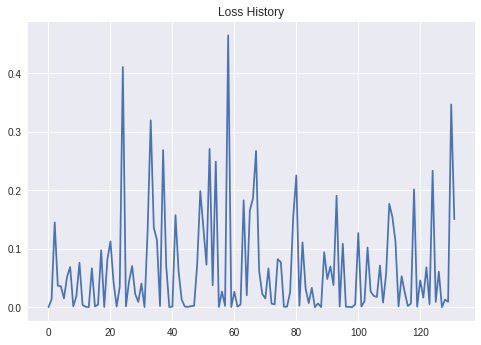

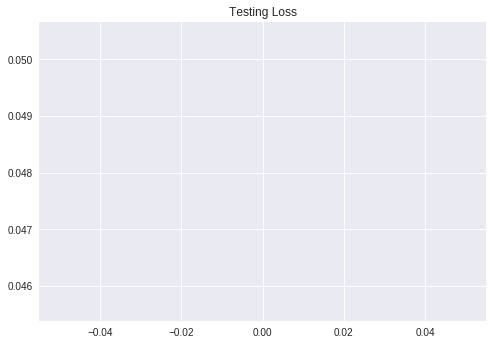

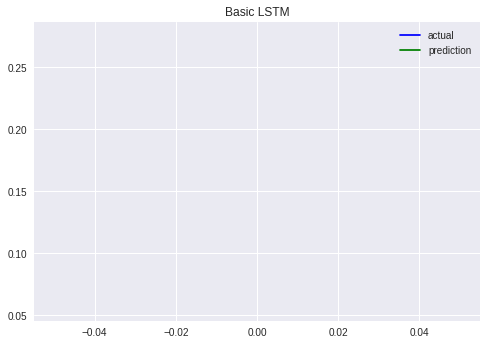

In [115]:
LOOKBACK_WINDOW = 15
PREDICT_WINDOW = 1
BATCH_SIZE = 1 #e.g if 3, then trains with 3 samples/lookback windows, each with 15 timesteps and 2 features at once.
HIDDEN = 32
DROPOUT = 0.3
OPTIMIZER = 'adam'
EPOCHS = 3
 
model,history,predictions,actuals,scores = basic_LSTM_model(BATCH_SIZE,HIDDEN,LOOKBACK_WINDOW,DROPOUT,OPTIMIZER,EPOCHS,input_mat,targets)
evaluate_walk_forward_LSTM(model,history,predictions,actuals,scores)